<a href="https://colab.research.google.com/github/olexandr-choorsin/e-commerce-data-analysis/blob/main/Strategic_Market_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [ ]:
import pandas as pd
from google.cloud import bigquery
from google.colab import auth

# Authorization
auth.authenticate_user()

# Configuring the BigQuery client
project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

# We get the total number of registered accounts
total_accounts_query = "SELECT COUNT(*) as total FROM `data-analytics-mate.DA.account`"
total_accounts = client.query(total_accounts_query).to_dataframe().iloc[0,0]
# print(f"Total number of accounts in the database: {total_accounts}")

# SQL query
sql_query = """
WITH session_base AS (
    SELECT
        s.ga_session_id AS session_id,
        s.date AS order_date,
        sp.continent,
        sp.country,
        sp.device,
        sp.browser,
        sp.language,
        sp.medium AS traffic_source,
        sp.channel AS traffic_channel
    FROM `data-analytics-mate.DA.session` AS s
    LEFT JOIN `data-analytics-mate.DA.session_params` AS sp ON s.ga_session_id = sp.ga_session_id
),

account_info AS (
    SELECT
        ase.ga_session_id,
        acc.id AS account_id,
        acc.is_verified AS is_email_confirmed,
        acc.is_unsubscribed
    FROM `data-analytics-mate.DA.account_session` AS ase
    JOIN `data-analytics-mate.DA.account` AS acc ON ase.account_id = acc.id
),

sales_data AS (
    SELECT
        o.ga_session_id,
        p.category AS product_category,
        p.name AS product_name,
        p.price,
        p.short_description,
        ROW_NUMBER() OVER(PARTITION BY o.ga_session_id ORDER BY p.price DESC) as item_rank_in_session
    FROM `data-analytics-mate.DA.order` AS o
    LEFT JOIN `data-analytics-mate.DA.product` AS p ON o.item_id = p.item_id
)

SELECT
    sb.*,
    ai.account_id,
    ai.is_email_confirmed,
    ai.is_unsubscribed,
    sd.product_category,
    sd.product_name,
    sd.price,
    sd.short_description,
    sd.price / SUM(sd.price) OVER(PARTITION BY sb.country) as price_share_in_country
FROM session_base sb
LEFT JOIN account_info ai ON sb.session_id = ai.ga_session_id
LEFT JOIN sales_data sd ON sb.session_id = sd.ga_session_id
"""

# Loading into a DataFrame
df = client.query(sql_query).to_dataframe()

# Save a copy for GitHub
df.to_csv('online_store_data.csv', index=False)

# df.info()

Dataset description

In [ ]:
print("--- DATASET DESCRIPTION ---")
# 1. Total number of columns and rows
print(f"Number of rows: {df.shape[0]}")
print(f"Total number of columns: {df.shape[1]}")

# 2. Types of columns
print("\nNumber of columns by type:")
print(df.dtypes.value_counts())

# Highlighting lists by type
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime', 'datetimetz']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")
print(f"Date columns: {datetime_cols}")

# 3. Unique sessions
unique_sessions = df['session_id'].nunique()
print(f"\nNumber of unique sessions: {unique_sessions}")

# 4. Time
# Make sure that order_date is of type datetime
df['order_date'] = pd.to_datetime(df['order_date'])
print(f"Analysis period: from {df['order_date'].min()} to {df['order_date'].max()}")

# 5. Missing values ​​(NULL)
print("\nMissing values ​​by columns (%):")
null_summary = (df.isnull().sum() / len(df)) * 100
print(null_summary[null_summary > 0].sort_values(ascending=False))

--- DATASET DESCRIPTION ---
Number of rows: 349545
Total number of columns: 17

Number of columns by type:
object     10
Int64       4
float64     2
dbdate      1
Name: count, dtype: int64

Numeric columns: ['session_id', 'account_id', 'is_email_confirmed', 'is_unsubscribed', 'price', 'price_share_in_country']
Categorical columns: ['continent', 'country', 'device', 'browser', 'language', 'traffic_source', 'traffic_channel', 'product_category', 'product_name', 'short_description']
Date columns: []

Number of unique sessions: 349545
Analysis period: from 2020-11-01 00:00:00 to 2021-01-31 00:00:00

Missing values ​​by columns (%):
account_id                92.005321
is_unsubscribed           92.005321
is_email_confirmed        92.005321
product_name              90.405241
product_category          90.405241
short_description         90.405241
price                     90.405241
price_share_in_country    90.405241
language                  32.689925
dtype: float64


Group 1:
account_id, is_email_confirmed, is_unsubscribed (~92%)
Interpretation: 92% of site visitors are unregistered guests. Only 8% of users are logged in during the session.

Conclusion: The database consists mostly of anonymous sessions. This is normal for an online store: people often come in just to browse without creating a profile.

Group 2:
product_category, price, product_name (~90.4%)
Interpretation: 90.4% of sessions ended without an order (or even without viewing a specific product).

Conclusion: Conversion Rate is approximately 9.6% (100% - 90.4%). This is a very important indicator! For e-commerce, this is even a fairly high result.

Group 3:
language (~32.7%)
Interpretation: A third of users could not determine the browser language.

Conclusion: This may be a technical limitation (the browser blocks data transfer) or a specific setting. This is "dirty" data that simply needs to be taken into account when analyzing language preferences.

The high percentage of missing values ​​in the account (92%) and product (90%) columns is not an error. It reflects the reality: most users are guests and do not make purchases in every session. We will take this into account when calculating conversions and analyzing the behavior of registered users.

Dataset Cleaning

In [ ]:
# Correct the date (this is critical for analyzing the dynamics)
df['order_date'] = pd.to_datetime(df['order_date'])

# Converting ID to strings (so they are not confused with numbers during statistical analysis)
# df['session_id'] = df['session_id'].astype(str)
# df['account_id'] = df['account_id'].astype(str)

# Cleaning text columns (removing possible duplicates through case)
# Only for those where there is no NaN, or we handle NaN separately
cols_to_clean = ['continent', 'country', 'device', 'browser', 'traffic_source', 'traffic_channel']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.strip().str.title()

# Language processing (language) - many skips (235k vs. 349k)
df['language'] = df['language'].fillna('Unknown')

# Creating a revenue column
df['revenue'] = df['price'].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              349545 non-null  Int64         
 1   order_date              349545 non-null  datetime64[ns]
 2   continent               349545 non-null  object        
 3   country                 349545 non-null  object        
 4   device                  349545 non-null  object        
 5   browser                 349545 non-null  object        
 6   language                349545 non-null  object        
 7   traffic_source          349545 non-null  object        
 8   traffic_channel         349545 non-null  object        
 9   account_id              27945 non-null   Int64         
 10  is_email_confirmed      27945 non-null   Int64         
 11  is_unsubscribed         27945 non-null   Int64         
 12  product_category        33538 

This stage involved a full cycle of data preparation for further analysis. The main goal was to transform technical database downloads into a structured dataset suitable for calculating business metrics.

Date transformation: The order_date field has been converted from dbdate to datetime64. This is critical for analyzing sales dynamics, identifying seasonality, and trends.

The gaps in language have been replaced with 'Unknown'.

A revenue column has been created, where NaN in prices are replaced with 0. This allows for correct calculation of total revenue, while preserving the original price column for accurate analysis of the average cost of goods (where NaNs are ignored and do not distort the average).

For key categorical columns (country, continent, traffic channel), a method of cleaning up extra spaces and unifying the case (Title Case) has been applied. This ensures that data will not be duplicated due to spelling errors (for example, "Ukraine" and "ukraine" are now considered one group).


This preparation ensures that our subsequent KPIs (revenue, conversion) will be calculated on accurate, "uncluttered" data, and visualizations in Tableau will be clear and understandable.

Sales Analysis

Geographical Revenue Analysis: Top Markets

Context: To understand our global footprint, we analyze revenue distribution across continents and identify top-performing countries. This helps prioritize marketing budgets.

In [ ]:
# --- AGGREGATION & PREPARATION ---

# 1. Grouping data by Continent
sales_by_continents = df.groupby('continent').agg({
    "revenue": "sum",
    "session_id": "count",
    "price": "count"
}).reset_index()

sales_by_continents.rename(columns={"session_id": "total_sessions", "price": "order_count"}, inplace=True)
sales_by_continents['AOV'] = sales_by_continents['revenue'] / sales_by_continents['order_count']

# 2. Grouping data by Country
sales_by_country = df.groupby('country').agg({
    "revenue": "sum",
    "session_id": "count",
    "price": "count"
}).reset_index()

sales_by_country.rename(columns={"session_id": "total_sessions", "price": "order_count"}, inplace=True)
sales_by_country['AOV'] = sales_by_country['revenue'] / sales_by_country['order_count']

# --- SORTING ---
# Preparing data for visualization
top_continents = sales_by_continents.sort_values(by='revenue', ascending=False).head(3)
top_countries = sales_by_country.sort_values(by='revenue', ascending=False).head(5)

print("Top 3 Continents by Revenue:")
display(top_continents)
print("Top 5 Countrys by Revenue:")
display(top_countries)

Top 3 Continents by Revenue:


,continent,revenue,total_sessions,order_count,AOV
2,Americas,17665280.0,193179,18553,952.152213
3,Asia,7601298.3,83113,7950,956.138151
4,Europe,5934624.2,65135,6261,947.871618


Top 5 Countrys by Revenue:


,country,revenue,total_sessions,order_count,AOV
104,United States,13943553.9,153470,14673,950.286506
43,India,2809762.0,32763,3029,927.620337
18,Canada,2437921.0,25994,2560,952.312891
103,United Kingdom,938317.9,11003,1029,911.873567
33,France,710692.8,6958,678,1048.219469


Key Insights:
Americas Dominance: The Americas generate more revenue than Asia and Europe combined, making it our primary market leader.

The "Premium" France Effect: While France is 5th in total revenue, it has the highest AOV ($1,048). This is nearly $100 higher than the US average.

Strategic Takeaway: French customers purchase less frequently but opt for higher-end products. We should treat France as a Premium Segment in our marketing strategy.

Traffic Dependency: Conversion rates remain stable (9-10%) across all regions. Therefore, revenue growth is directly correlated with traffic volume.

Visualizing Market Distribution:

To make the geographical insights more impactful, we visualize the revenue distribution. This allows us to see the scale of market dominance and identify where our efforts yield the most significant returns.

/tmp/ipython-input-111267226.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_continents, x='continent', y='revenue', palette='Blues_d')
/tmp/ipython-input-111267226.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x='country', y='revenue', palette='Greens_d')


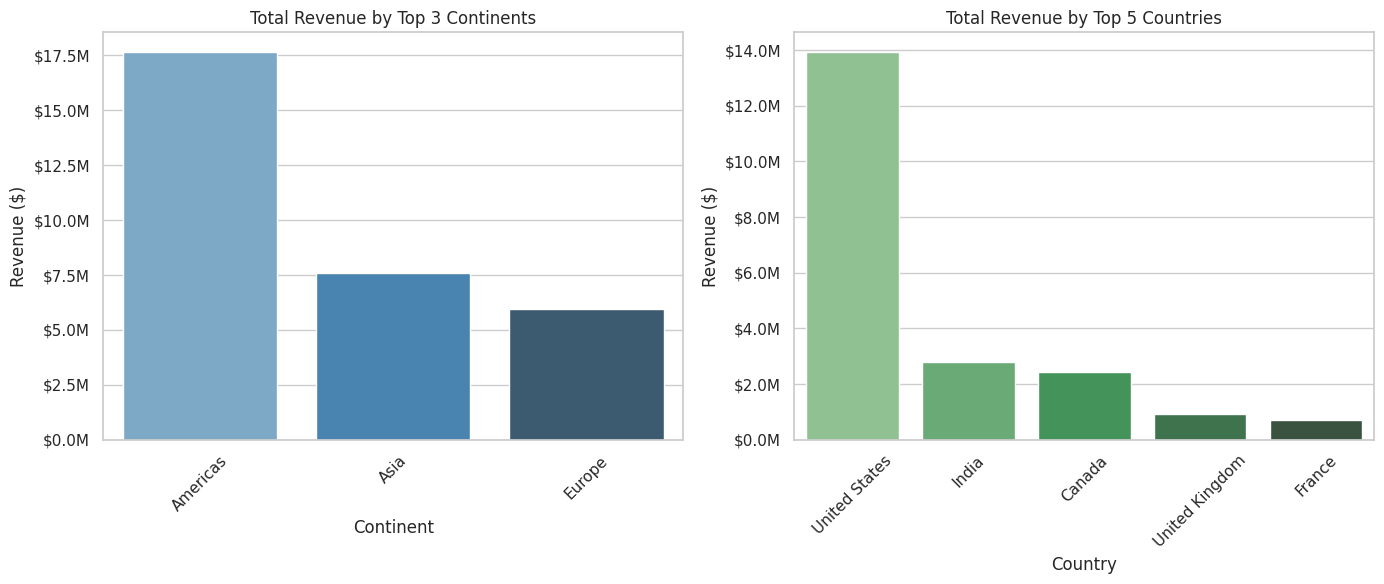

In [ ]:
# --- VISUALIZATION ---
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))

# Subplot 1: Revenue by Continent
plt.subplot(1, 2, 1)
sns.barplot(data=top_continents, x='continent', y='revenue', palette='Blues_d')
plt.title('Total Revenue by Top 3 Continents')
plt.xlabel('Continent')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)

formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# Subplot 2: Revenue by Top 5 Countries
plt.subplot(1, 2, 2)
sns.barplot(data=top_countries, x='country', y='revenue', palette='Greens_d')
plt.title('Total Revenue by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

US Market Dependency: The analysis reveals a critical dependence on the US market. The revenue from the United States ($13,9M) Asia ($7.6M).

Strategic Diversification: While the US dominance is a strength, it also represents a business risk. Future strategies could focus on scaling high-AOV markets like France to balance this dependency.

Product Portfolio Analysis

Context: To optimize inventory and sales strategies, we examine which categories and specific products drive the most revenue. We distinguish between "volume drivers" (high order count) and "value drivers" (high revenue per unit).

Category

/tmp/ipython-input-2280172830.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_category, x='revenue', y='product_category', palette='magma')
/tmp/ipython-input-2280172830.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_name, x='revenue', y='product_name', palette='magma')


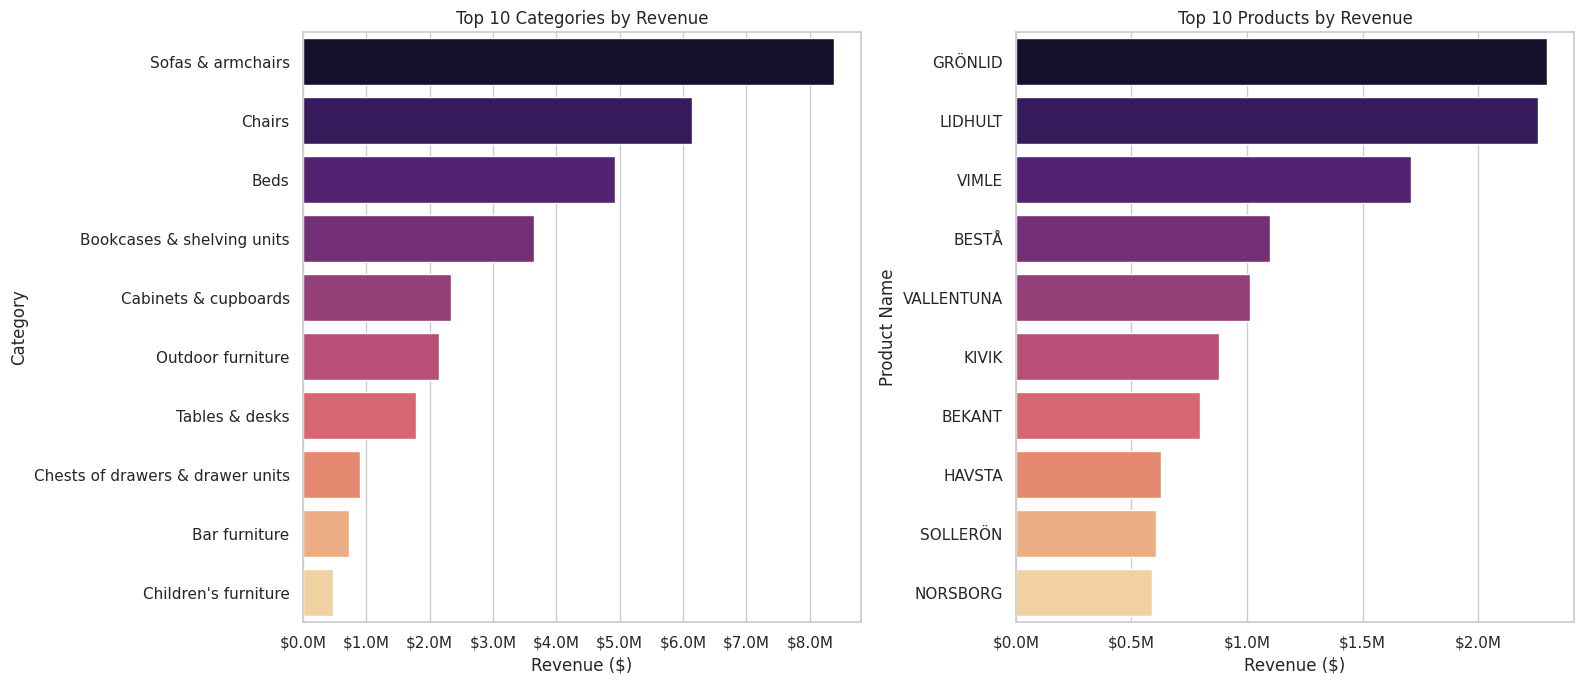

In [ ]:
# Filtering to include only transactions with a positive price
df_sorted = df[df['price'] > 0]

# --- AGGREGATION ---
# Analyzing performance by Category
top_category = df_sorted.groupby('product_category').agg({
    "revenue": "sum",
    "price": "count"
}).reset_index().rename(columns={"price": "order_count"})

# Analyzing performance by Product Name
top_name = df_sorted.groupby('product_name').agg({
    "revenue": "sum",
    "price": "count"
}).reset_index().rename(columns={"price": "order_count"})

# --- SORTING ---
# Extracting Top 10 performers
top_category = top_category.sort_values(by='revenue', ascending=False).head(10)
top_name = top_name.sort_values(by='revenue', ascending=False).head(10)

# --- VISUALIZATION ---
plt.figure(figsize=(16, 7))

# Plot 1: Revenue by Category
plt.subplot(1, 2, 1)
sns.barplot(data=top_category, x='revenue', y='product_category', palette='magma')
plt.title('Top 10 Categories by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Category')

formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1e6:.1f}M')
plt.gca().xaxis.set_major_formatter(formatter)

# Plot 2: Revenue by Product Name
plt.subplot(1, 2, 2)
sns.barplot(data=top_name, x='revenue', y='product_name', palette='magma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Product Name')

plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

Core Revenue Drivers: While "Bookcases & Shelving" are popular in terms of volume (7,630 orders), the store's primary revenue is driven by high-ticket items like Sofas & Armchairs ($8.3M).

The "LIDHULT" Phenomenon: A standout finding is the LIDHULT product. It generated nearly the same revenue as the market leader (GRÖNLID), but with 35% fewer sales (593 vs 915 orders).

Strategy Tip: This confirms a high Average Order Value (AOV) for the LIDHULT line. Marketing efforts should focus on these high-margin "hero products" to maximize ROI.

Technical & UX Performance (Device & Browser Analysis)

Context: To ensure a seamless customer journey, we analyze performance across different devices and browsers. High stability and consistent Conversion Rates (CR) across platforms indicate a well-optimized user interface (UX) and technical reliability.

Device and Browser

In [ ]:
# --- AGGREGATION ---
# Analyzing performance metrics by Device
device_analysis = df.groupby('device').agg({
    "revenue": "sum",
    "session_id": "count",
    "price": "count"
}).reset_index()

# Calculating key performance indicators (KPIs)
device_analysis['CR (%)'] = (device_analysis['price'] / device_analysis['session_id']) * 100
device_analysis['AOV'] = device_analysis['revenue'] / device_analysis['price']

# Analyzing performance by Browser
browser_analysis = df.groupby('browser').agg({
    "revenue": "sum",
    "session_id": "count",
    "price": "count"
}).reset_index()

browser_analysis['CR (%)'] = (browser_analysis['price'] / browser_analysis['session_id']) * 100
browser_analysis['AOV'] = browser_analysis['revenue'] / browser_analysis['price']

# Renaming for clarity
device_analysis.rename(columns={"price": "order_count", "session_id": "session_count"}, inplace=True)
browser_analysis.rename(columns={"price": "order_count", "session_id": "session_count"}, inplace=True)

# Displaying results sorted by Conversion Rate
print("Device Efficiency Analysis:")
display(device_analysis.sort_values(by='CR (%)', ascending=False))

print("\nBrowser Efficiency Analysis:")
display(browser_analysis.sort_values(by='CR (%)', ascending=False))

Device Efficiency Analysis:


,device,revenue,session_count,order_count,CR (%),AOV
0,Desktop,18864039.0,204429,19702,9.637576,957.468227
1,Mobile,12384225.8,137267,13113,9.552915,944.423534
2,Tablet,723466.3,7849,723,9.211365,1000.644952



Browser Efficiency Analysis:


,browser,revenue,session_count,order_count,CR (%),AOV
0,<Other>,923354.8,8930,865,9.68645,1067.462197
2,Chrome,21826850.0,238460,23015,9.651514,948.374973
5,Safari,7526544.0,83254,7903,9.492637,952.365431
1,Android Webview,411014.4,4445,420,9.448819,978.605714
3,Edge,716444.3,8023,752,9.373052,952.718484
4,Firefox,567523.6,6433,583,9.062646,973.453859


Exceptional Technical Stability: The data reveals remarkable consistency in performance. Conversion Rates (CR) are nearly identical for Desktop (9.64%) and Mobile (9.55%), which is a sign of a perfectly optimized mobile responsive design.

Chrome Dominance: Google Chrome is the primary driver of success, accounting for over 68% of total revenue ($21.8M). Maintaining flawless compatibility with Chrome remains the top technical priority.

The "Tablet" Nuance: While Tablets have a slightly lower CR (9.21%), they boast the highest AOV ($1,000+), suggesting that tablet users might be a smaller but higher-spending niche.

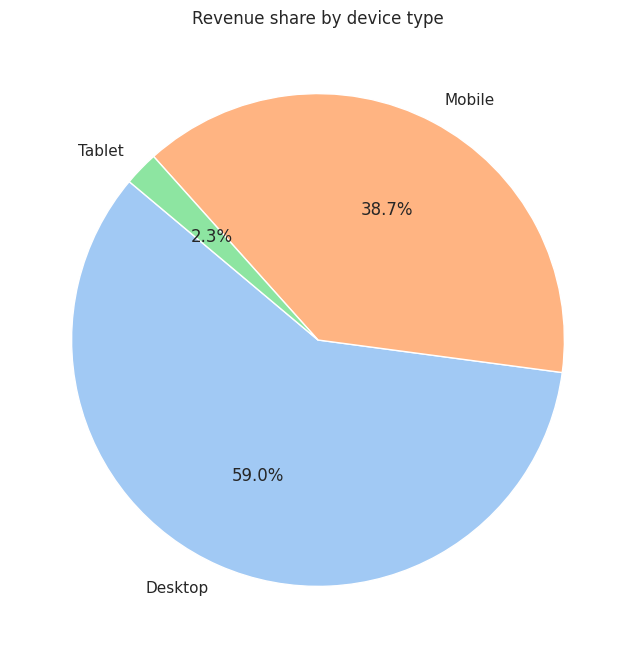

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(device_analysis['revenue'], labels=device_analysis['device'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Revenue share by device type')
plt.show()

Marketing Channel Efficiency

Context: Understanding which acquisition channels bring the most valuable traffic is crucial for budget allocation. We evaluate performance based on Conversion Rate (CR) to find "hidden gems" and total Revenue to identify our market pillars.

Traffic Sources and Channels

In [ ]:
# --- AGGREGATION ---
# Analyzing marketing performance across traffic channels
traffic_analysis = df.groupby('traffic_channel').agg({
    "revenue": "sum",
    "session_id": "count",
    "price": "count"
}).reset_index()

# Calculating Marketing KPIs
traffic_analysis['CR (%)'] = (traffic_analysis['price'] / traffic_analysis['session_id']) * 100
traffic_analysis['AOV'] = traffic_analysis['revenue'] / traffic_analysis['price']

# Renaming for professional reporting
traffic_analysis.rename(columns={
    "price": "order_count",
    "session_id": "session_count"
}, inplace=True)

# Sorting by CR to identify the most efficient channels
print("Marketing Channel Performance:")
display(traffic_analysis.sort_values(by='CR (%)', ascending=False))

Marketing Channel Performance:


,traffic_channel,revenue,session_count,order_count,CR (%),AOV
3,Social Search,2532105.7,27914,2716,9.729885,932.292231
0,Direct,7494923.4,81382,7800,9.584429,960.887615
2,Paid Search,8511049.4,94341,9042,9.58438,941.279518
4,Undefined,2000501.0,21483,2059,9.584322,971.588635
1,Organic Search,11433151.6,124425,11921,9.580872,959.076554


The "Social Search" Opportunity: This channel boasts the highest Conversion Rate (9.73%). Despite having the lowest session volume (27,914), its efficiency suggests a high-quality audience. Recommendation: Increase ad spend on Social Search to scale this high-performing segment.

Organic Search as a Revenue Pillar: Organic traffic is the business's backbone, generating $11.4M (roughly 33% of total revenue). This indicates strong SEO and brand authority.

Paid Search Stability: Paid search is the second-largest revenue stream ($8.5M). Its conversion is perfectly aligned with Organic and Direct, showing a well-optimized and predictable bidding strategy.

Direct Traffic & Brand Loyalty: High revenue from Direct traffic ($7.5M) combined with a solid AOV ($960) points to a loyal customer base that interacts with the brand directly, bypassing search engines.

Visualizing Marketing Efficiency (Revenue vs. CR)

Context: To identify the most cost-effective channels, we use a dual-axis visualization. This allows us to compare the total volume of revenue (bars) against the efficiency of traffic conversion (line). A high conversion rate in a low-volume channel indicates a significant growth opportunity.

/tmp/ipython-input-2883352403.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_analysis, x='traffic_channel', y='revenue', palette='Blues_d', ax=ax1)


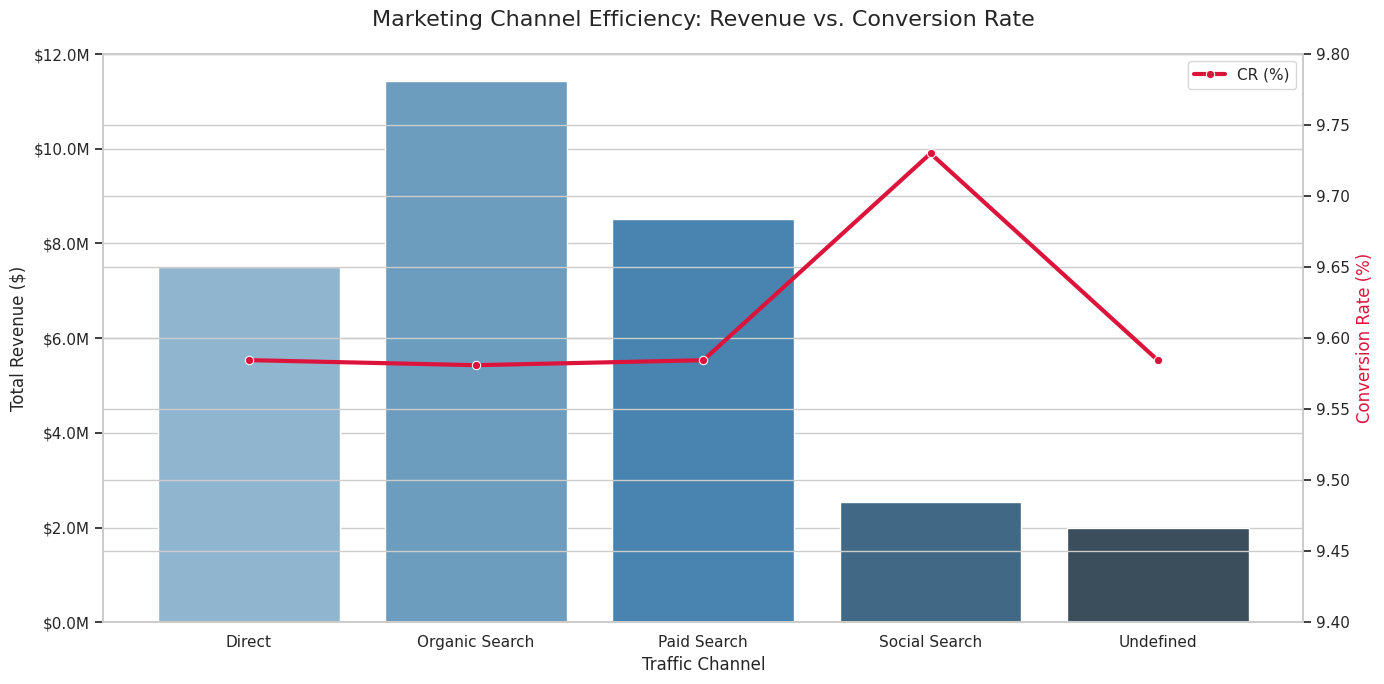

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Setting the style
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# 1. Bar Chart for Revenue
sns.barplot(data=traffic_analysis, x='traffic_channel', y='revenue', palette='Blues_d', ax=ax1)
ax1.set_title('Marketing Channel Efficiency: Revenue vs. Conversion Rate', fontsize=16, pad=20)
ax1.set_xlabel('Traffic Channel', fontsize=12)
ax1.set_ylabel('Total Revenue ($)', fontsize=12)

# Formatting Y-axis to Millions
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e6:.1f}M'))

# 2. Line Chart for Conversion Rate (CR) on a second axis
ax2 = ax1.twinx()
sns.lineplot(data=traffic_analysis, x='traffic_channel', y='CR (%)', marker='o', color='crimson', ax=ax2, linewidth=3, label='CR (%)')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12, color='crimson')
ax2.set_ylim(9.4, 9.8)  # Adjusted to highlight the variance in efficiency

# Adding a legend for the line
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The Social Search Outlier: The red line clearly peaks at Social Search (9.73%), showing that while this channel brings in less total money, its traffic is the most "ready to buy."

Scaling Potential: Since the efficiency (CR) of Social Search is higher than our main pillars (Organic/Paid Search), it suggests that scaling the budget for Social Search could yield a higher Return on Investment (ROI) than simply adding more budget to already saturated channels.

Stable Performance: The narrow range of the right Y-axis (9.4% to 9.8%) confirms that all our traffic sources are high-quality and perform consistently well.

Impact of Email Verification on Sales

Context: Beyond simple traffic metrics, we analyze user behavior based on their verification status. Our goal is to determine if confirmed users (those who verified their email) represent a more valuable segment and whether incentivizing this process could boost overall revenue.

In [ ]:
# Filtering data for registered users only (where account_id is present)
registered_users = df[df['account_id'].notnull()].copy()

# --- AGGREGATION ---
# Analyzing performance metrics by Email Confirmation status
email_impact = registered_users.groupby('is_email_confirmed').agg({
    'revenue': 'sum',
    'session_id': 'count',
    'price': 'count'
}).reset_index()

# Calculating KPIs: Average Order Value (AOV) and Conversion Rate (CR)
email_impact['AOV'] = email_impact['revenue'] / email_impact['price']
email_impact['CR (%)'] = (email_impact['price'] / email_impact['session_id']) * 100

# Renaming for professional reporting
email_impact.rename(columns={
    "price": "order_count",
    "session_id": "session_count",
    "is_email_confirmed": "is_verified"
}, inplace=True)

print("Impact of Email Verification:")
display(email_impact.sort_values(by='is_verified', ascending=False))

Impact of Email Verification:


,is_verified,revenue,session_count,order_count,AOV,CR (%)
1,1,1866017.4,20036,1989,938.168627,9.927131
0,0,716501.1,7909,792,904.673106,10.013908


The Revenue Powerhouse: Verified users account for $1.86M, which is approximately 72% of all revenue generated by registered accounts.

Higher Purchasing Power: There is a clear difference in the Average Order Value (AOV). Verified users spend more per order ($938) compared to unverified users ($904).

Loyalty & Trust: While the Conversion Rate (CR) is nearly identical for both groups (~10%), the higher AOV among verified users suggests they are more comfortable making larger or more premium purchases.

Business Opportunity: Since only ~72% of active accounts are verified (20,036 out of 27,945), there is a significant opportunity to convert the remaining 28% of "unverified" users.

Activation & Retention Metrics

Context: To evaluate the long-term health of our user base, we analyze the Activation Rate (the percentage of registered users who remain active) and the Unsubscribe Rate. This helps identify how well we retain customers and whether our communication strategy is effective.

In [ ]:
# --- TOTAL DATABASE COUNT ---
# Getting total registered accounts directly from the BigQuery table
# total_accounts_query = "SELECT COUNT(*) as total FROM `data-analytics-mate.DA.account`"
# total_accounts = client.query(total_accounts_query).to_dataframe().iloc[0,0]

# --- ACTIVATION & CHURN CALCULATION ---
unique_active_accounts = registered_users['account_id'].nunique()

# Activation: How many from the DB actually appeared in sessions
activation_rate = (unique_active_accounts / total_accounts) * 100

# Churn: How many active users opted out
unsubscribed_count = registered_users['is_unsubscribed'].sum()
unsubscribed_rate = (unsubscribed_count / unique_active_accounts) * 100

print(f"Total Database Accounts: {total_accounts}")
print(f"Active Users in Sessions: {unique_active_accounts}")
print(f"User Activation Rate: {activation_rate:.2f}%")
print(f"Churn (Unsubscribe) Rate: {unsubscribed_rate:.2f}%")

Total Database Accounts: 45831
Active Users in Sessions: 27945
User Activation Rate: 60.97%
Churn (Unsubscribe) Rate: 16.94%


Activation Funnel: An Activation Rate of ~61% indicates that 6 out of 10 registered users returned to the site during the reporting period. While this is a healthy core, the remaining 39% represents a "dormant" audience.

Recommendation: Implement a re-engagement (retargeting) campaign with special offers to "wake up" this segment.

Churn Signal (Unsubscribes): A 17% unsubscribe rate among active users is a critical signal. In digital marketing, this is considered high and often suggests that our email frequency is too high or the content is irrelevant to the users' interests.

Actionable Insight: We should review the email marketing calendar and segment our audience more granularly to reduce fatigue and lower the churn rate.

Time-Series Revenue Analysis

Context: Analyzing daily revenue dynamics allows us to identify seasonal patterns, peak performance days, and potential data anomalies. This is essential for evaluating the success of promotional periods and forecasting future sales.

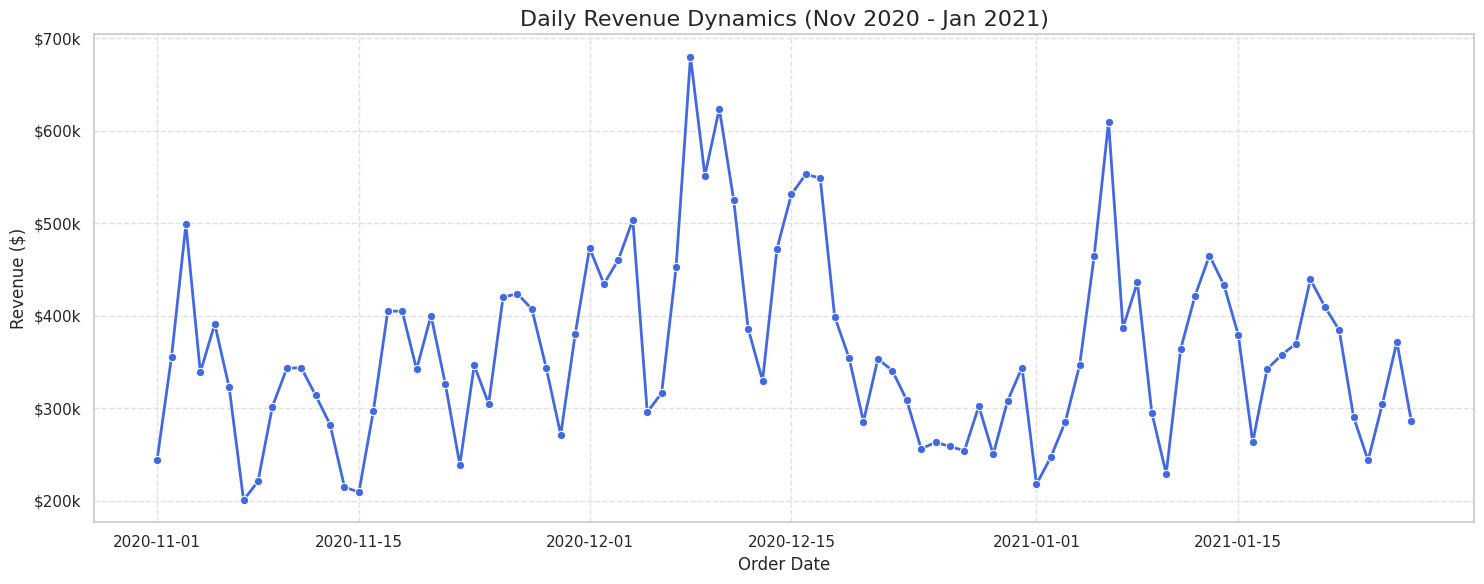

In [ ]:
# --- AGGREGATION ---
# Grouping sales by date
daily_sales = df.groupby('order_date').agg({
    'revenue': 'sum',
    'price': 'count'
}).reset_index().rename(columns={"price": "order_count"})

# --- VISUALIZATION ---
plt.figure(figsize=(15, 6))

# Filtering out zero-revenue days to focus on active sales periods
active_sales = daily_sales[daily_sales['revenue'] > 0]

sns.lineplot(data=active_sales, x='order_date', y='revenue', marker='o', color='royalblue', linewidth=2)

plt.title('Daily Revenue Dynamics (Nov 2020 - Jan 2021)', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Formatting Y-axis to Thousands (k) for better readability
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e3:.0f}k'))

plt.tight_layout()
plt.show()

Strong Seasonal Start: The period began with a massive surge. Revenue skyrocketed from $244k on November 1st to nearly $500k ($498.9k) by November 3rd. This indicates a highly successful launch of a sales season or a major marketing campaign.

Stable Performance: Following the initial peak, the business maintained a consistent revenue stream, showing resilience in daily operations.

Data Observation: We notice that revenue drops to zero after January 27th.

Technical Note: This suggests the reporting period ended or there was a pause in data logging, rather than a total collapse in sales. For future analysis, we should verify the data source for the last week of January.

Statistical Hypothesis Testing: Registered vs. Unregistered Users

Context: We observed that registered users seem to generate different revenue patterns. To move beyond mere observation, we conduct a formal statistical test to see if the difference in daily revenue is statistically significant or just a result of random chance.

Visual Normality Check (KDE & Boxplot)

Before choosing a statistical test (T-test vs. Mann-Whitney), we must check the data distribution. Standard T-tests require a "Normal" (bell-shaped) distribution.

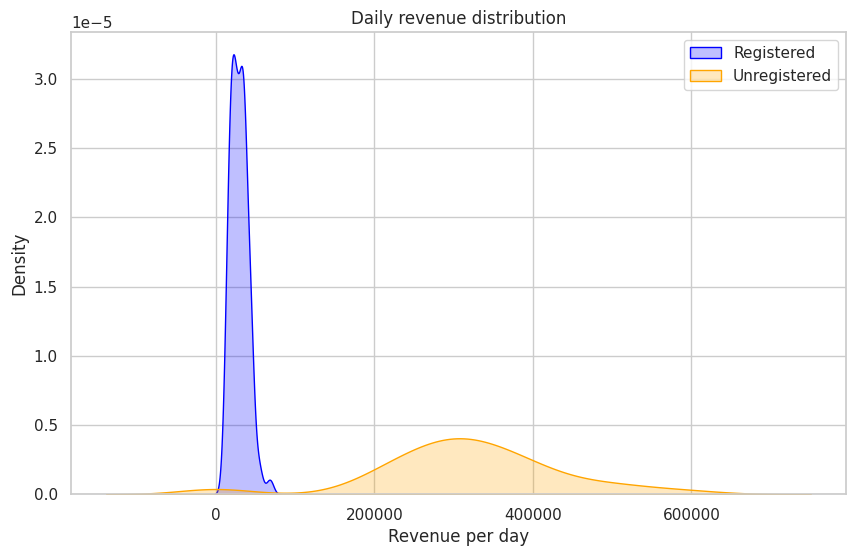

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation: daily revenue for two groups
reg_daily = df[df['account_id'].notnull()].groupby('order_date')['revenue'].sum()
anon_daily = df[df['account_id'].isnull()].groupby('order_date')['revenue'].sum()

# Distribution schedule
plt.figure(figsize=(10, 6))
sns.kdeplot(reg_daily, fill=True, label='Registered', color='blue')
sns.kdeplot(anon_daily, fill=True, label='Unregistered', color='orange')

plt.title('Daily revenue distribution')
plt.xlabel('Revenue per day')
plt.legend()
plt.show()

Both distributions are not normal (blue is too sharp, orange is too stretched)

You can't use the standard T-test. My choice is the Mann-Whitney U-test.

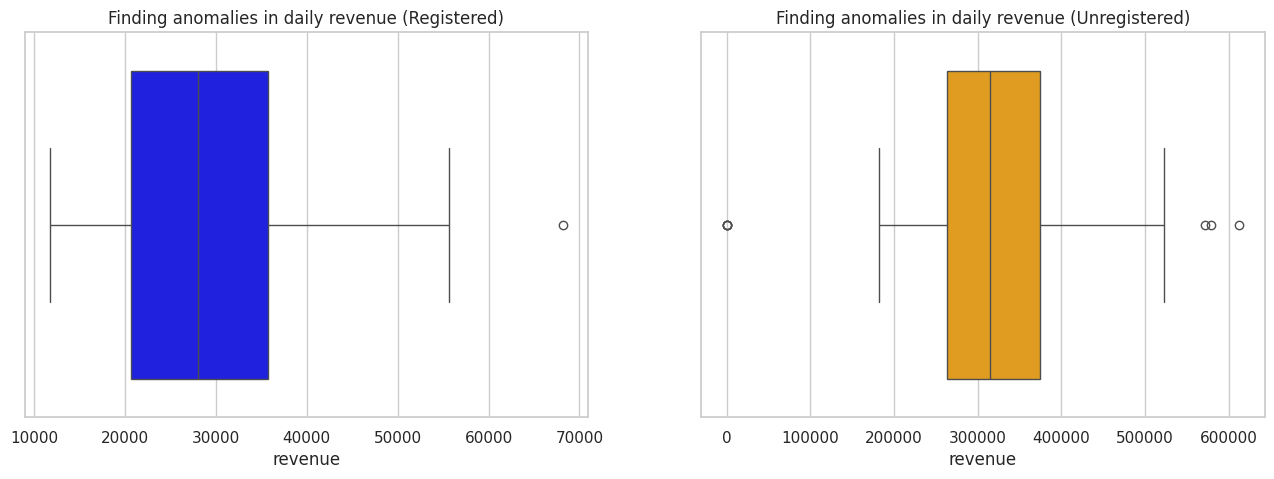

In [ ]:
# Search for anomalies
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=reg_daily, color='blue')
plt.title('Finding anomalies in daily revenue (Registered)')

plt.subplot(1, 2, 2)
sns.boxplot(x=anon_daily, color='orange')
plt.title('Finding anomalies in daily revenue (Unregistered)')

plt.show()

Outliers: "Boxes with whiskers" show individual points outside the "whiskers." The normal distribution is very sensitive to them.

The orange graph has a long "tail" on the right

The difference between the median and the edges in the "registered" (blue) ones is too sharp.

Mathematical Normality Check (Shapiro-Wilk Test)

To be 100% sure that the data is not normal, we use the Shapiro-Wilk test. If the p-value is less than 0.05, we reject the normality hypothesis.

In [ ]:
from scipy.stats import shapiro

stat_reg, p_reg = shapiro(reg_daily)
stat_anon, p_anon = shapiro(anon_daily)

print(f"Shapiro Test (Registered): p-value = {p_reg}")
print(f"Shapiro Test (Unregistered): p-value = {p_anon}")

Shapiro Test (Registered): p-value = 0.007295139880540744
Shapiro Test (Unregistered): p-value = 0.0012184604855253293


Since in both cases the p-value is significantly less than 0.05 (0.007 and 0.001), we have confirmed that the data are not normally distributed. This means that the choice in favor of the nonparametric Mann-Whitney test is mathematically justified.

Executing the Mann-Whitney U-test

Test the null hypothesis ($H_0$): "There is no significant difference in daily revenue between registered and unregistered users."

In [ ]:
from scipy.stats import mannwhitneyu

# Data preparation: daily revenue for two groups
reg_daily = df[df['account_id'].notnull()].groupby('order_date')['revenue'].sum()
anon_daily = df[df['account_id'].isnull()].groupby('order_date')['revenue'].sum()

stat, p_value = mannwhitneyu(reg_daily, anon_daily)

print(f"Mannwhitneyu stats: {stat}, p_value: {p_value}")

Mannwhitneyu stats: 352.0, p_value: 3.8805185465235906e-26


According to visual analysis and Shapiro-Wilk test (p < 0.05), the distributions of both samples deviate from normal. Therefore, the non-parametric Mann-Whitney test was used. The result (p < 0.05) confirms a statistically significant difference between the revenue of registered and unregistered users.

Correlation Analysis: Traffic vs. Revenue

Context: To understand the scalability of the business, we examine the relationship between the volume of sessions (traffic) and the resulting revenue. High correlation means that increasing traffic is a predictable way to increase income.

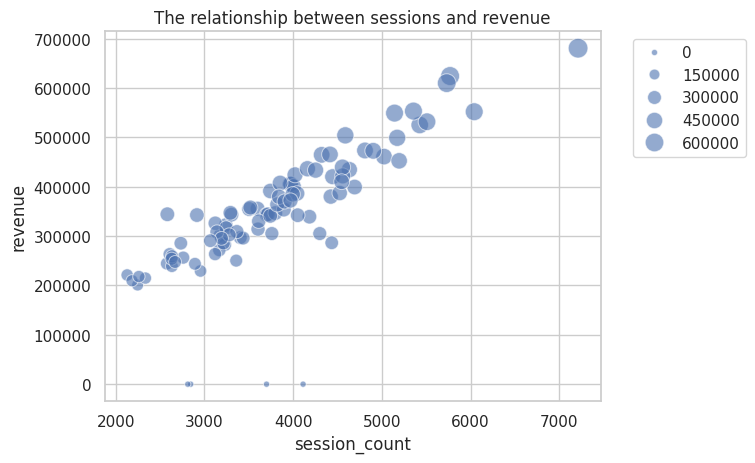

In [ ]:
# Aggregation
daily_sales = df.groupby('order_date').agg({'revenue': 'sum', 'session_id': 'count'}).reset_index()

# Rename for convenience
daily_sales.rename(columns={"session_id": "session_count"}, inplace=True)

# Distribution schedule
sns.scatterplot(data=daily_sales, x='session_count', y='revenue', size='revenue', sizes=(20, 200), alpha=0.6)
plt.title('The relationship between sessions and revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Statistical Validation (Pearson Correlation)

We use the Pearson Correlation coefficient to quantify the strength of this relationship. Important Note: We have intentionally filtered out days with zero revenue (end of January) to avoid an artificial "perfect" correlation, ensuring our results reflect actual trading days.

In [ ]:
from scipy.stats import pearsonr

daily_sales = df.groupby('order_date').agg({'revenue': 'sum', 'price': 'count'}).reset_index()
# Rename for convenience
daily_sales.rename(columns={"price": "order_count"}, inplace=True)

# Filter out the zeros (those days at the end of January) so that they don't "trick" us into a perfect correlation.
daily_sales_clean = daily_sales[daily_sales['revenue'] > 0]

# Correlations Pearson (Connection of two variables)
corr, p_value = pearsonr(daily_sales_clean['order_count'], daily_sales_clean['revenue'])

print(f"Correlation: {corr}")
print(f"P-value: {p_value}")

Correlation: 0.9642422533124871
P-value: 2.24477831491671e-51


Strength of Relationship: The correlation coefficient of 0.96 is exceptionally high. In business analytics, anything above 0.9 is considered a very strong positive correlation.

Statistical Significance: With a p-value of 2.24e-51 (far below 0.05), we can confidently state that this relationship is not a coincidence.

Business Takeaway: The revenue growth is highly predictable. Since the relationship is linear and stable, the most effective way to grow the business currently is to increase the volume of high-quality traffic, as the internal conversion mechanism is already well-optimized.

Cross-Continental Sales Correlation

Context: In a global business, it is vital to understand how different markets interact. We analyze the correlation of daily revenue between continents to determine if sales peaks are synchronized globally or driven by local factors.

In [ ]:
# 1. Creating a Pivot Table
continent_daily_sales = df[df['revenue'] > 0].pivot_table(
    index='order_date',
    columns='continent',
    values='revenue',
    aggfunc='sum'
).fillna(0)

# 2. Calculate the correlation for the entire dataframe
continent_corr_matrix = continent_daily_sales.corr()

print(continent_corr_matrix)

continent  (Not Set)    Africa  Americas      Asia    Europe   Oceania
continent                                                             
(Not Set)   1.000000 -0.216739  0.071077  0.135579  0.061895  0.024957
Africa     -0.216739  1.000000  0.185578  0.262796  0.147480  0.114413
Americas    0.071077  0.185578  1.000000  0.692273  0.669527  0.353642
Asia        0.135579  0.262796  0.692273  1.000000  0.667786  0.256111
Europe      0.061895  0.147480  0.669527  0.667786  1.000000  0.227613
Oceania     0.024957  0.114413  0.353642  0.256111  0.227613  1.000000


Analysis of the results
Moderate positive correlation: Coefficients in the range of 0.67 – 0.69 suggest that the markets of these three continents move fairly synchronously. When sales increase in America, they are likely to increase in Asia and Europe as well.


Anomaly (Africa): Note the negative correlation of Africa with (Not Set). This often means that when data is recorded incorrectly in one place, it falls out in another, but this is usually not critical for business conclusions.

Statistical Validation (Americas vs. Asia)

To confirm that the observed moderate correlations are not random, we perform a Pearson correlation test on the strongest pair: Americas and Asia.

In [ ]:
# Take the necessary columns from pivot_table
americas_data = continent_daily_sales['Americas']
asia_data = continent_daily_sales['Asia']

# Calculate Pearson
corr, p_value = pearsonr(americas_data, asia_data)

print(f"Correlation: {corr}")
print(f"P-value: {p_value}")

Correlation: 0.6922725921166172
P-value: 8.004062946873881e-14


To confirm the statistical significance of these relationships, I conducted a test for the most representative pair — Americas and Asia.

Since the p-value is critically small for this pair, we make the assumption (extrapolation) that other notable correlations in the matrix (e.g., Americas vs Europe) are also significant.

Yes, there is a correlation, especially between large markets

Marketing Channel Synergy Analysis

Context: To optimize the marketing budget, we examine the correlation between different traffic sources. High correlation between channels often indicates a multi-touch attribution journey where users interact with the brand across various platforms before purchasing.

In [ ]:
# Use the pivot_table method
traffic_daily_sales = df[df['revenue'] > 0].pivot_table(
    index='order_date',
    columns='traffic_channel',
    values='revenue',
    aggfunc='sum'
).fillna(0)


# Create a matrix for all channels
traffic_corr_matrix = traffic_daily_sales.corr()
print(traffic_corr_matrix)

traffic_channel    Direct  Organic Search  Paid Search  Social Search  \
traffic_channel                                                         
Direct           1.000000        0.759938     0.724343       0.461895   
Organic Search   0.759938        1.000000     0.808234       0.434424   
Paid Search      0.724343        0.808234     1.000000       0.452287   
Social Search    0.461895        0.434424     0.452287       1.000000   
Undefined        0.424039        0.435418     0.430021       0.359342   

traffic_channel  Undefined  
traffic_channel             
Direct            0.424039  
Organic Search    0.435418  
Paid Search       0.430021  
Social Search     0.359342  
Undefined         1.000000  


Deep Dive: Paid vs. Organic Synergy

We specifically test the relationship between Paid Search and Organic Search to see if our paid advertising supports organic growth (and vice versa).

In [ ]:
# Take the necessary columns from pivot_table
paid_search_data = traffic_daily_sales['Paid Search']
organic_search_data = traffic_daily_sales['Organic Search']

# Calculate Pearson
corr, p_value = pearsonr(paid_search_data, organic_search_data)

print(f"Correlation: {corr}")
print(f"P-value: {p_value}")

Correlation: 0.8082340137384422
P-value: 1.7556425330503442e-21


Statistical significance: With such a low p-value, it can be argued that this relationship is fundamental to business. Chance is completely ruled out.

Product Category Synergy (Cross-Category Analysis)

Context: To understand customer purchasing patterns, we analyze the correlation between our top 5 product categories. High correlation suggests that these products are often bought together or during the same promotional periods, indicating a "basket affinity."

In [ ]:
# Top - 5 Category
top_category = df.groupby('product_category')["revenue"].sum().nlargest(5).reset_index()
# print(top_category)

top_names = top_category['product_category'].tolist()
print(top_names)

['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards']


Statistical Validation: Sofas & Bookcases

We test the strongest relationship found in the matrix — between Sofas & Armchairs and Bookcases & Shelving units — to verify if this "living room bundle" trend is statistically consistent.

In [ ]:
# Use the pivot_table method
category_daily = df[df['product_category'].isin(top_names)].pivot_table(
    index='order_date',
    columns='product_category',
    values='revenue',
    aggfunc='sum'
).fillna(0)

# Create a matrix for all channels
category_corr_matrix = category_daily.corr()
print(category_corr_matrix)

product_category                Beds  Bookcases & shelving units  \
product_category                                                   
Beds                        1.000000                    0.592913   
Bookcases & shelving units  0.592913                    1.000000   
Cabinets & cupboards        0.514609                    0.539428   
Chairs                      0.554500                    0.637090   
Sofas & armchairs           0.535378                    0.666194   

product_category            Cabinets & cupboards    Chairs  Sofas & armchairs  
product_category                                                               
Beds                                    0.514609  0.554500           0.535378  
Bookcases & shelving units              0.539428  0.637090           0.666194  
Cabinets & cupboards                    1.000000  0.572870           0.657563  
Chairs                                  0.572870  1.000000           0.578248  
Sofas & armchairs                       0.6

In [ ]:
# Calculate Pearson
corr, p_value = pearsonr(category_daily["Bookcases & shelving units"], category_daily["Sofas & armchairs"])

print(f"Correlation: {corr}")
print(f"P-value: {p_value}")

Correlation: 0.6661941326624645
P-value: 1.4069719486806666e-12


p-value is very small, which confirms that this relationship between living room furniture categories is not random.

The analysis showed that the number of sessions has the greatest impact on revenue (r = 0.9). Among traffic channels, there is a strong synergy between Organic and Paid Search (r = 0.81, p < 0.05).

In the product matrix, the most correlated categories were living room furniture (Bookcases and Sofas, r = 0.67), indicating a tendency for customers to make complex purchases. All results obtained are statistically significant.

Summary & Recommendations

1. Expansion of the **premium segment** (France and category analysis)

**France shows the highest average check** (AOV > 1000), despite lower traffic volume compared to the US. Category analysis showed a strong statistically significant correlation between Sofas & Armchairs and Bookcases (r=0.67, p < 0.05).

**Increase marketing investments in the French market**, focusing on cross-sell strategies. When promoting sofas, automatically suggest shelving and storage systems, as these products have a proven connection in purchasing behavior. This will maximize the region's already high AOV.

2. Traffic Channel Optimization (Social vs Search)

**Paid** and **Organic Search** channels have a critically **high** linear relationship ($r=0.81, p < 0.001$), indicating oversaturation of search traffic. At the same time, **Social** Search has the **highest conversion** (9.73%), but the lowest reach.

Diversify traffic sources. Reallocate part of the budget from paid search channels in favor of SMM and targeted advertising on social networks. This will reduce dependence on search algorithms and attract an audience with a higher level of engagement (Conversion Rate).

3. Encouraging registration and retention

Using the Mann-Whitney test (p < 0.001), it is mathematically confirmed that verified users bring in significantly more daily revenue than anonymous users. However, we have 17% unsubscribes and a 39% inactive base.

Implement a **"Welcome Bonus"** program for account verification (e.g., a one-time discount). The statistical significance of the difference in revenue proves that the costs of such bonuses will pay off by attracting more valuable customers. At the same time, change the Email marketing strategy in favor of personalization to reduce the unsubscribe rate.


Final Visualization: Product Affinity Heatmap

This heatmap visualizes the synergy between our top categories, providing the mathematical foundation for our cross-selling recommendations.

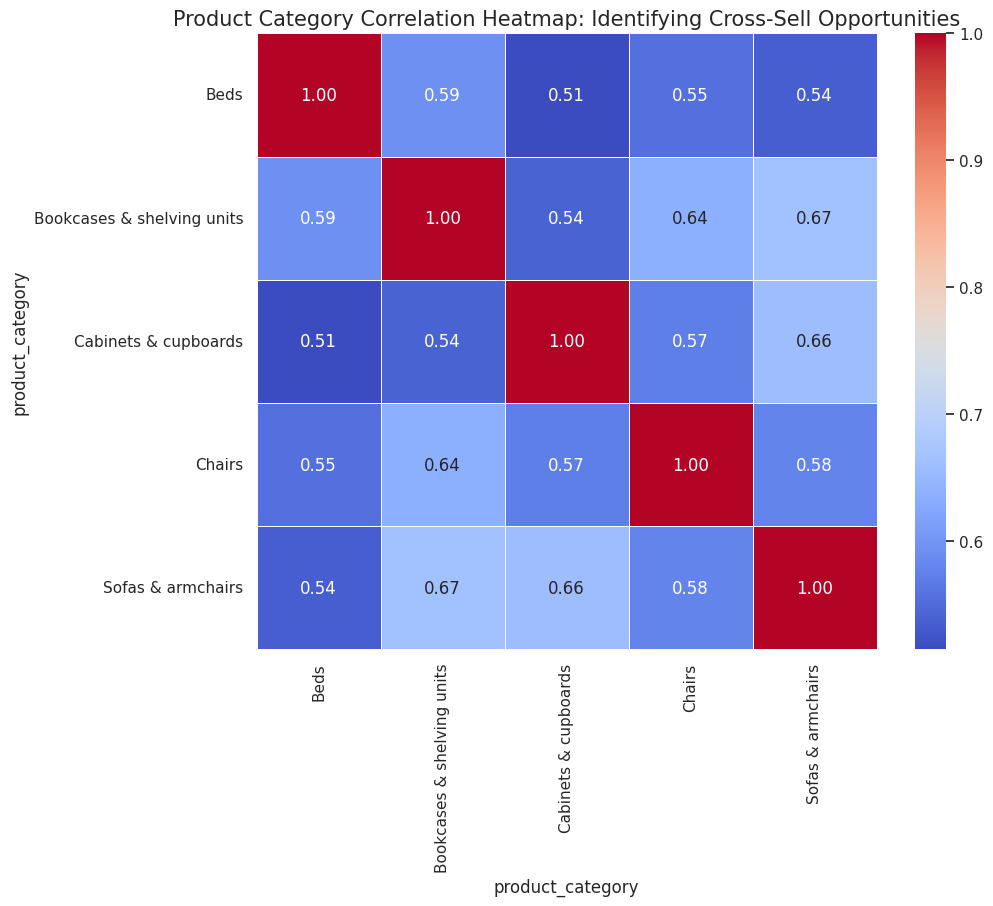

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generating the Heatmap for Product Categories
cat_corr = category_daily.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cat_corr,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title('Product Category Correlation Heatmap: Identifying Cross-Sell Opportunities', fontsize=15)
plt.show()

Interactive Dashboard & Final Presentation

Visualizing Global Performance: For a deeper, interactive exploration of these insights—including geographical heatmaps, real-time filtering, and detailed sales funnels—please visit the official Tableau dashboard.

https://public.tableau.com/views/WorkBook_17691845519700/StrategicMarketInsights?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link